# Exercise Sheet 3: Multi Layer Perceptrons (MLPs)

In [104]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.datasets import make_moons

import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 4.0)

import pprint
pp = pprint.PrettyPrinter(indent=4)


# Set random seed for reproducibility
SEED = 42
RESULTS_PATH = "./results"

### Task 1: Backpropagation and Simple Training

In [105]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

#set_seed(SEED)

In [106]:
def standard_normalization(x):
    return (x - x.mean()) / x.std()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def normaldist_init(input_size, output_size):
    # Normal distribution initialization
    return torch.randn(input_size, output_size)
    
def xavier_init(input_size, output_size):
    # Xavier initialization
    return torch.randn(input_size, output_size) * np.sqrt(2.0/(input_size + output_size))

In [107]:
# 1. Complete forward, backward pass, and update for Linear and ReLU
class Linear:
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # initialize weights with standard normal distribution and bias with zeros
        # self.weight = normaldist_init(self.in_channels, self.out_channels)
        
        # Xavier initialization
        self.weight = xavier_init(self.in_channels, self.out_channels)
        self.bias = torch.zeros(self.out_channels)
        
        # store last input for backpropagation
        self.last_input = None
        self.grad_weight = None
        self.grad_bias = None
        
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x

        # reshape input to 2D tensor
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)

        # calculate linear transformation
        newx = torch.matmul(x, self.weight) + self.bias
        return newx
    
    def backward(self, gradient):
        # calculate gradients
        self.grad_weight = torch.matmul(self.last_input.t(), gradient)
        self.grad_bias = torch.sum(gradient, dim=0)
        
        # reshape gradient to original input shape
        if len(self.last_input.shape) > 2:
            gradient = gradient.view(*self.last_input.shape)

        # calculate gradient for previous layer
        newgrad = torch.matmul(gradient, self.weight.t())

        return newgrad

    
    def update(self, learning_rate):
        # update weights and bias
        self.weight -= learning_rate * self.grad_weight
        self.bias -= learning_rate * self.grad_bias
        
        
class ReLU:
    def __init__(self):
        self.last_input = None
    
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x
        
        # ReLU activation
        newx = torch.max(x, torch.zeros_like(x))
        return newx
    
    def backward(self, gradient):
        # ReLU gradient
        newgrad = torch.where(self.last_input>0, gradient, 0.0)
        return newgrad
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass
    

In [108]:
class Softmax:
    def __init__(self, dim=-1):
        self.last_output = None
        self.dim = dim
        
    def forward(self, x, remember=False):
        x = torch.exp(x-torch.amax(x, dim=-1, keepdims=True)) #numerical stable version -> normalize by max(x)
        x = x/(torch.sum(x, dim=self.dim, keepdim=True)+1e-12)
        if remember:
            self.last_output = x
        return x
    
    def backward(self, gradient):
        jacobian = -self.last_output[:,:,None]*self.last_output[:,None,:] #BxLxL
        #correct diagonal entries
        jacobian += torch.eye(self.last_output.size(-1)).unsqueeze(0)*self.last_output.unsqueeze(-1).repeat(1,1,self.last_output.size(-1))
        return torch.einsum("bj,bji->bi", gradient, jacobian)
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass

In [109]:
class CrossEntropyLoss:
    def __init__(self, dim=-1):
        self.last_input = None
        self.last_ground_truth = None
        self.dim = dim
    
    def forward(self, p, y):
        #convert y to one hot
        one_hot = torch.eye(p.size(-1))[y]
        self.last_input = p
        self.last_ground_truth = one_hot
        
        losses = -torch.sum(one_hot*torch.log(p), dim=-1)
        total_loss = torch.mean(losses)
        
        return total_loss
    
    def backward(self):
        return torch.where(self.last_ground_truth==1,-1.0/self.last_input, 0.0)

              

In [110]:
class MLP:
    def __init__(self, in_channels=2, hidden_channels=[], out_channels=2):
        self.in_channels = in_channels
        
        self.layers = []
        if len(hidden_channels)==0:
            self.layers.append(Linear(in_channels, out_channels))
        else:
            self.layers.append(Linear(in_channels, hidden_channels[0]))
            self.layers.append(ReLU())
            for i in range(len(hidden_channels)-1):
                self.layers.append(Linear(hidden_channels[i], hidden_channels[i+1]))
                self.layers.append(ReLU())
            self.layers.append(Linear(hidden_channels[-1], out_channels))
        self.layers.append(Softmax(dim=-1))
        
        self.criterion = CrossEntropyLoss(dim=-1)
        
    def forward(self, x, remember=False):
        for layer in self.layers:
            x = layer.forward(x, remember=remember)
        return x
    
    def backward(self): #calculate gradients
        grad = self.criterion.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self, learning_rate): #update each layer via gradient descent
        for layer in self.layers:
            layer.update(learning_rate)
    
    def training_step(self, x, y, learning_rate):
        probabilities = self.forward(x, remember=True) #store inputs for backward pass!
        loss = self.criterion.forward(probabilities, y)
        self.backward() #calculate gradients
        self.update(learning_rate) #update using gradient descent
        
        return loss

In [111]:
def train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=10, batch_size=32, learning_rate=5e-3):
    num_batches_train = int(np.ceil(Ntrain/batch_size))
    num_batches_test = int(np.ceil(Ntest/batch_size))

    #train network
    losses_train = []
    losses_test = []

    for epoch in range(num_epochs):
        #reshuffle training data
        ind = np.random.permutation(len(Xtrain))
        Xtrain = Xtrain[ind]
        ytrain = ytrain[ind]

        epoch_train_loss = 0.0
        epoch_test_loss = 0.0

        #training pass
        for it in tqdm(range(num_batches_train)):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtrain))
            X = torch.FloatTensor(Xtrain[start:end])
            y = torch.LongTensor(ytrain[start:end])

            # compute loss and update weights
            loss = mlp.training_step(X, y, learning_rate)
            epoch_train_loss += loss.item()

            # update weights
            mlp.update(learning_rate)

            if it%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Iteration {it+1}/{num_batches_train}, Train Loss: {loss.item()}")

        #testing pass
        for it in range(num_batches_test):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtest))
            X = torch.FloatTensor(Xtest[start:end])
            y = torch.LongTensor(ytest[start:end])

            # compute loss
            probabilities = mlp.forward(X)
            loss = mlp.criterion.forward(probabilities, y)
            epoch_test_loss += loss.item()

            if it%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Iteration {it+1}/{num_batches_test}, Test Loss: {loss.item()}")

        # append average loss for this epoch
        losses_train.append(epoch_train_loss / num_batches_train)
        losses_test.append(epoch_test_loss / num_batches_test)

    return losses_train, losses_test


In [112]:
#create datasets
Ntrain = 8000
Ntest = 2000
Xtrain, ytrain = make_moons(n_samples=Ntrain, noise=0.08, random_state=42)
Xtest, ytest = make_moons(n_samples=Ntest, noise=0.08, random_state=42)

print(Xtrain.shape, ytrain.shape)

(8000, 2) (8000,)


In [113]:
# 2. Implement missing parts in the training routine

# rescale data to [-1,1]
amin = np.amin(Xtrain, axis=0, keepdims=True)
amax = np.amax(Xtrain, axis=0, keepdims=True)

Xtrain = ((Xtrain-amin)/(amax-amin)-0.5)/0.5
Xtest = ((Xtest-amin)/(amax-amin)-0.5)/0.5

batch_size = 32
num_epochs = 10
learning_rate = 3e-2

# create MLP
hidden_channels = [30,30]
mlp = MLP(2, hidden_channels, 2)

losses_train = []
losses_test = []

# train network
losses_train, losses_test = train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)


100%|██████████| 250/250 [00:00<00:00, 4969.11it/s]


Epoch 1/10, Iteration 1/250, Train Loss: 0.6846792697906494
Epoch 1/10, Iteration 11/250, Train Loss: 0.2679646909236908
Epoch 1/10, Iteration 21/250, Train Loss: 0.37059512734413147
Epoch 1/10, Iteration 31/250, Train Loss: 0.3638851046562195
Epoch 1/10, Iteration 41/250, Train Loss: 0.1850566565990448
Epoch 1/10, Iteration 51/250, Train Loss: 0.2450941503047943
Epoch 1/10, Iteration 61/250, Train Loss: 0.26097479462623596
Epoch 1/10, Iteration 71/250, Train Loss: 0.08931903541088104
Epoch 1/10, Iteration 81/250, Train Loss: 0.21651621162891388
Epoch 1/10, Iteration 91/250, Train Loss: 0.11709441244602203
Epoch 1/10, Iteration 101/250, Train Loss: 0.13976186513900757
Epoch 1/10, Iteration 111/250, Train Loss: 0.47429507970809937
Epoch 1/10, Iteration 121/250, Train Loss: 0.22850868105888367
Epoch 1/10, Iteration 131/250, Train Loss: 0.20116060972213745
Epoch 1/10, Iteration 141/250, Train Loss: 0.11985840648412704
Epoch 1/10, Iteration 151/250, Train Loss: 0.22688043117523193
Epoch 1/

100%|██████████| 250/250 [00:00<00:00, 5573.14it/s]


Epoch 2/10, Iteration 1/250, Train Loss: 0.13697224855422974
Epoch 2/10, Iteration 11/250, Train Loss: 0.08898402750492096
Epoch 2/10, Iteration 21/250, Train Loss: 0.37443336844444275
Epoch 2/10, Iteration 31/250, Train Loss: 0.1920943707227707
Epoch 2/10, Iteration 41/250, Train Loss: 0.21313272416591644
Epoch 2/10, Iteration 51/250, Train Loss: 0.9947255253791809
Epoch 2/10, Iteration 61/250, Train Loss: 0.1805454045534134
Epoch 2/10, Iteration 71/250, Train Loss: 0.08439021557569504
Epoch 2/10, Iteration 81/250, Train Loss: 0.09560005366802216
Epoch 2/10, Iteration 91/250, Train Loss: 0.08071015775203705
Epoch 2/10, Iteration 101/250, Train Loss: 0.10775014013051987
Epoch 2/10, Iteration 111/250, Train Loss: 0.00960184633731842
Epoch 2/10, Iteration 121/250, Train Loss: 0.019735995680093765
Epoch 2/10, Iteration 131/250, Train Loss: 0.03924282267689705
Epoch 2/10, Iteration 141/250, Train Loss: 0.0038101410027593374
Epoch 2/10, Iteration 151/250, Train Loss: 0.002758847316727042
Ep

100%|██████████| 250/250 [00:00<00:00, 5637.99it/s]


Epoch 3/10, Iteration 1/250, Train Loss: nan
Epoch 3/10, Iteration 11/250, Train Loss: nan
Epoch 3/10, Iteration 21/250, Train Loss: nan
Epoch 3/10, Iteration 31/250, Train Loss: nan
Epoch 3/10, Iteration 41/250, Train Loss: nan
Epoch 3/10, Iteration 51/250, Train Loss: nan
Epoch 3/10, Iteration 61/250, Train Loss: nan
Epoch 3/10, Iteration 71/250, Train Loss: nan
Epoch 3/10, Iteration 81/250, Train Loss: nan
Epoch 3/10, Iteration 91/250, Train Loss: nan
Epoch 3/10, Iteration 101/250, Train Loss: nan
Epoch 3/10, Iteration 111/250, Train Loss: nan
Epoch 3/10, Iteration 121/250, Train Loss: nan
Epoch 3/10, Iteration 131/250, Train Loss: nan
Epoch 3/10, Iteration 141/250, Train Loss: nan
Epoch 3/10, Iteration 151/250, Train Loss: nan
Epoch 3/10, Iteration 161/250, Train Loss: nan
Epoch 3/10, Iteration 171/250, Train Loss: nan
Epoch 3/10, Iteration 181/250, Train Loss: nan
Epoch 3/10, Iteration 191/250, Train Loss: nan
Epoch 3/10, Iteration 201/250, Train Loss: nan
Epoch 3/10, Iteration 21

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10, Iteration 1/250, Train Loss: nan
Epoch 4/10, Iteration 11/250, Train Loss: nan
Epoch 4/10, Iteration 21/250, Train Loss: nan
Epoch 4/10, Iteration 31/250, Train Loss: nan
Epoch 4/10, Iteration 41/250, Train Loss: nan
Epoch 4/10, Iteration 51/250, Train Loss: nan
Epoch 4/10, Iteration 61/250, Train Loss: nan
Epoch 4/10, Iteration 71/250, Train Loss: nan
Epoch 4/10, Iteration 81/250, Train Loss: nan
Epoch 4/10, Iteration 91/250, Train Loss: nan
Epoch 4/10, Iteration 101/250, Train Loss: nan
Epoch 4/10, Iteration 111/250, Train Loss: nan
Epoch 4/10, Iteration 121/250, Train Loss: nan
Epoch 4/10, Iteration 131/250, Train Loss: nan
Epoch 4/10, Iteration 141/250, Train Loss: nan
Epoch 4/10, Iteration 151/250, Train Loss: nan
Epoch 4/10, Iteration 161/250, Train Loss: nan
Epoch 4/10, Iteration 171/250, Train Loss: nan
Epoch 4/10, Iteration 181/250, Train Loss: nan
Epoch 4/10, Iteration 191/250, Train Loss: nan


100%|██████████| 250/250 [00:00<00:00, 5592.97it/s]


Epoch 4/10, Iteration 201/250, Train Loss: nan
Epoch 4/10, Iteration 211/250, Train Loss: nan
Epoch 4/10, Iteration 221/250, Train Loss: nan
Epoch 4/10, Iteration 231/250, Train Loss: nan
Epoch 4/10, Iteration 241/250, Train Loss: nan
Epoch 4/10, Iteration 1/63, Test Loss: nan
Epoch 4/10, Iteration 11/63, Test Loss: nan
Epoch 4/10, Iteration 21/63, Test Loss: nan
Epoch 4/10, Iteration 31/63, Test Loss: nan
Epoch 4/10, Iteration 41/63, Test Loss: nan
Epoch 4/10, Iteration 51/63, Test Loss: nan
Epoch 4/10, Iteration 61/63, Test Loss: nan


100%|██████████| 250/250 [00:00<00:00, 5647.95it/s]


Epoch 5/10, Iteration 1/250, Train Loss: nan
Epoch 5/10, Iteration 11/250, Train Loss: nan
Epoch 5/10, Iteration 21/250, Train Loss: nan
Epoch 5/10, Iteration 31/250, Train Loss: nan
Epoch 5/10, Iteration 41/250, Train Loss: nan
Epoch 5/10, Iteration 51/250, Train Loss: nan
Epoch 5/10, Iteration 61/250, Train Loss: nan
Epoch 5/10, Iteration 71/250, Train Loss: nan
Epoch 5/10, Iteration 81/250, Train Loss: nan
Epoch 5/10, Iteration 91/250, Train Loss: nan
Epoch 5/10, Iteration 101/250, Train Loss: nan
Epoch 5/10, Iteration 111/250, Train Loss: nan
Epoch 5/10, Iteration 121/250, Train Loss: nan
Epoch 5/10, Iteration 131/250, Train Loss: nan
Epoch 5/10, Iteration 141/250, Train Loss: nan
Epoch 5/10, Iteration 151/250, Train Loss: nan
Epoch 5/10, Iteration 161/250, Train Loss: nan
Epoch 5/10, Iteration 171/250, Train Loss: nan
Epoch 5/10, Iteration 181/250, Train Loss: nan
Epoch 5/10, Iteration 191/250, Train Loss: nan
Epoch 5/10, Iteration 201/250, Train Loss: nan
Epoch 5/10, Iteration 21

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10, Iteration 1/250, Train Loss: nan
Epoch 6/10, Iteration 11/250, Train Loss: nan


100%|██████████| 250/250 [00:00<00:00, 5465.80it/s]


Epoch 6/10, Iteration 21/250, Train Loss: nan
Epoch 6/10, Iteration 31/250, Train Loss: nan
Epoch 6/10, Iteration 41/250, Train Loss: nan
Epoch 6/10, Iteration 51/250, Train Loss: nan
Epoch 6/10, Iteration 61/250, Train Loss: nan
Epoch 6/10, Iteration 71/250, Train Loss: nan
Epoch 6/10, Iteration 81/250, Train Loss: nan
Epoch 6/10, Iteration 91/250, Train Loss: nan
Epoch 6/10, Iteration 101/250, Train Loss: nan
Epoch 6/10, Iteration 111/250, Train Loss: nan
Epoch 6/10, Iteration 121/250, Train Loss: nan
Epoch 6/10, Iteration 131/250, Train Loss: nan
Epoch 6/10, Iteration 141/250, Train Loss: nan
Epoch 6/10, Iteration 151/250, Train Loss: nan
Epoch 6/10, Iteration 161/250, Train Loss: nan
Epoch 6/10, Iteration 171/250, Train Loss: nan
Epoch 6/10, Iteration 181/250, Train Loss: nan
Epoch 6/10, Iteration 191/250, Train Loss: nan
Epoch 6/10, Iteration 201/250, Train Loss: nan
Epoch 6/10, Iteration 211/250, Train Loss: nan
Epoch 6/10, Iteration 221/250, Train Loss: nan
Epoch 6/10, Iteration

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10, Iteration 1/250, Train Loss: nan


100%|██████████| 250/250 [00:00<00:00, 5434.33it/s]


Epoch 7/10, Iteration 11/250, Train Loss: nan
Epoch 7/10, Iteration 21/250, Train Loss: nan
Epoch 7/10, Iteration 31/250, Train Loss: nan
Epoch 7/10, Iteration 41/250, Train Loss: nan
Epoch 7/10, Iteration 51/250, Train Loss: nan
Epoch 7/10, Iteration 61/250, Train Loss: nan
Epoch 7/10, Iteration 71/250, Train Loss: nan
Epoch 7/10, Iteration 81/250, Train Loss: nan
Epoch 7/10, Iteration 91/250, Train Loss: nan
Epoch 7/10, Iteration 101/250, Train Loss: nan
Epoch 7/10, Iteration 111/250, Train Loss: nan
Epoch 7/10, Iteration 121/250, Train Loss: nan
Epoch 7/10, Iteration 131/250, Train Loss: nan
Epoch 7/10, Iteration 141/250, Train Loss: nan
Epoch 7/10, Iteration 151/250, Train Loss: nan
Epoch 7/10, Iteration 161/250, Train Loss: nan
Epoch 7/10, Iteration 171/250, Train Loss: nan
Epoch 7/10, Iteration 181/250, Train Loss: nan
Epoch 7/10, Iteration 191/250, Train Loss: nan
Epoch 7/10, Iteration 201/250, Train Loss: nan
Epoch 7/10, Iteration 211/250, Train Loss: nan
Epoch 7/10, Iteration 

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10, Iteration 1/250, Train Loss: nan
Epoch 8/10, Iteration 11/250, Train Loss: nan
Epoch 8/10, Iteration 21/250, Train Loss: nan
Epoch 8/10, Iteration 31/250, Train Loss: nan
Epoch 8/10, Iteration 41/250, Train Loss: nan
Epoch 8/10, Iteration 51/250, Train Loss: nan
Epoch 8/10, Iteration 61/250, Train Loss: nan
Epoch 8/10, Iteration 71/250, Train Loss: nan
Epoch 8/10, Iteration 81/250, Train Loss: nan
Epoch 8/10, Iteration 91/250, Train Loss: nan
Epoch 8/10, Iteration 101/250, Train Loss: nan
Epoch 8/10, Iteration 111/250, Train Loss: nan
Epoch 8/10, Iteration 121/250, Train Loss: nan
Epoch 8/10, Iteration 131/250, Train Loss: nan
Epoch 8/10, Iteration 141/250, Train Loss: nan
Epoch 8/10, Iteration 151/250, Train Loss: nan
Epoch 8/10, Iteration 161/250, Train Loss: nan
Epoch 8/10, Iteration 171/250, Train Loss: nan
Epoch 8/10, Iteration 181/250, Train Loss: nan
Epoch 8/10, Iteration 191/250, Train Loss: nan
Epoch 8/10, Iteration 201/250, Train Loss: nan
Epoch 8/10, Iteration 21

100%|██████████| 250/250 [00:00<00:00, 5351.71it/s]

Epoch 8/10, Iteration 1/63, Test Loss: nan


Epoch 8/10, Iteration 11/63, Test Loss: nan
Epoch 8/10, Iteration 21/63, Test Loss: nan
Epoch 8/10, Iteration 31/63, Test Loss: nan
Epoch 8/10, Iteration 41/63, Test Loss: nan
Epoch 8/10, Iteration 51/63, Test Loss: nan
Epoch 8/10, Iteration 61/63, Test Loss: nan


100%|██████████| 250/250 [00:00<00:00, 5718.36it/s]


Epoch 9/10, Iteration 1/250, Train Loss: nan
Epoch 9/10, Iteration 11/250, Train Loss: nan
Epoch 9/10, Iteration 21/250, Train Loss: nan
Epoch 9/10, Iteration 31/250, Train Loss: nan
Epoch 9/10, Iteration 41/250, Train Loss: nan
Epoch 9/10, Iteration 51/250, Train Loss: nan
Epoch 9/10, Iteration 61/250, Train Loss: nan
Epoch 9/10, Iteration 71/250, Train Loss: nan
Epoch 9/10, Iteration 81/250, Train Loss: nan
Epoch 9/10, Iteration 91/250, Train Loss: nan
Epoch 9/10, Iteration 101/250, Train Loss: nan
Epoch 9/10, Iteration 111/250, Train Loss: nan
Epoch 9/10, Iteration 121/250, Train Loss: nan
Epoch 9/10, Iteration 131/250, Train Loss: nan
Epoch 9/10, Iteration 141/250, Train Loss: nan
Epoch 9/10, Iteration 151/250, Train Loss: nan
Epoch 9/10, Iteration 161/250, Train Loss: nan
Epoch 9/10, Iteration 171/250, Train Loss: nan
Epoch 9/10, Iteration 181/250, Train Loss: nan
Epoch 9/10, Iteration 191/250, Train Loss: nan
Epoch 9/10, Iteration 201/250, Train Loss: nan
Epoch 9/10, Iteration 21

100%|██████████| 250/250 [00:00<00:00, 5664.67it/s]


Epoch 10/10, Iteration 1/250, Train Loss: nan
Epoch 10/10, Iteration 11/250, Train Loss: nan
Epoch 10/10, Iteration 21/250, Train Loss: nan
Epoch 10/10, Iteration 31/250, Train Loss: nan
Epoch 10/10, Iteration 41/250, Train Loss: nan
Epoch 10/10, Iteration 51/250, Train Loss: nan
Epoch 10/10, Iteration 61/250, Train Loss: nan
Epoch 10/10, Iteration 71/250, Train Loss: nan
Epoch 10/10, Iteration 81/250, Train Loss: nan
Epoch 10/10, Iteration 91/250, Train Loss: nan
Epoch 10/10, Iteration 101/250, Train Loss: nan
Epoch 10/10, Iteration 111/250, Train Loss: nan
Epoch 10/10, Iteration 121/250, Train Loss: nan
Epoch 10/10, Iteration 131/250, Train Loss: nan
Epoch 10/10, Iteration 141/250, Train Loss: nan
Epoch 10/10, Iteration 151/250, Train Loss: nan
Epoch 10/10, Iteration 161/250, Train Loss: nan
Epoch 10/10, Iteration 171/250, Train Loss: nan
Epoch 10/10, Iteration 181/250, Train Loss: nan
Epoch 10/10, Iteration 191/250, Train Loss: nan
Epoch 10/10, Iteration 201/250, Train Loss: nan
Epo

In [114]:
def plot_loss_curves(losses_train, losses_test, path=RESULTS_PATH, file_name="losses"):
    plt.figure(figsize=(10, 6))
    plt.plot(losses_train, label="Training Loss", marker='o', markersize=4, linestyle='-', color='blue')
    plt.plot(losses_test, label="Testing Loss", marker='o', markersize=4, linestyle='-', color='red')
    plt.title("Loss Curves for Training and Testing Sets", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)

    # store plot in results folder
    # check if folder exists, if not create it
    if not os.path.exists(path):
        os.makedirs(path)

    plt.savefig(f"{path}/{file_name}.png", dpi=300)
    plt.show()


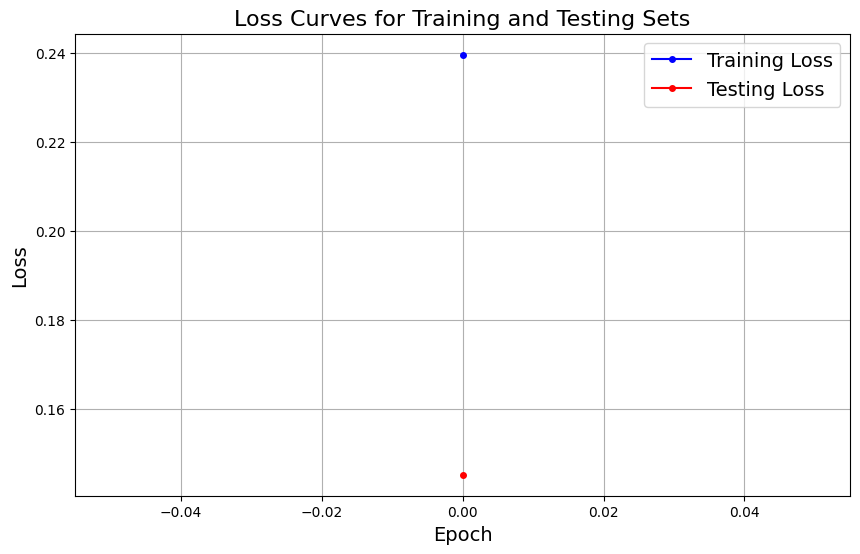

In [115]:
# 3. Plot loss curves on training and test set
plot_loss_curves(losses_train, losses_test, file_name="mlp_loss_curves_small_1")

In [116]:
# 4. Increase the number of hidden units and observe the effect on the loss curves
# create MLP
batch_size = 32
num_epochs = 10
learning_rate = 3e-2

hidden_channels = [30, 40, 50, 40, 30]
mlp = MLP(2, hidden_channels, 2)

losses_train = []
losses_test = []

# train network
losses_train, losses_test = train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)

100%|██████████| 250/250 [00:00<00:00, 3554.42it/s]


Epoch 1/10, Iteration 1/250, Train Loss: 0.6931173205375671
Epoch 1/10, Iteration 11/250, Train Loss: 0.6282324194908142
Epoch 1/10, Iteration 21/250, Train Loss: 0.728484034538269
Epoch 1/10, Iteration 31/250, Train Loss: 0.7104911804199219
Epoch 1/10, Iteration 41/250, Train Loss: 0.6648252010345459
Epoch 1/10, Iteration 51/250, Train Loss: 3.4570062160491943
Epoch 1/10, Iteration 61/250, Train Loss: 0.6319438815116882
Epoch 1/10, Iteration 71/250, Train Loss: 0.7228153347969055
Epoch 1/10, Iteration 81/250, Train Loss: 0.687254011631012
Epoch 1/10, Iteration 91/250, Train Loss: 0.6946790218353271
Epoch 1/10, Iteration 101/250, Train Loss: 0.7449804544448853
Epoch 1/10, Iteration 111/250, Train Loss: 0.6933919787406921
Epoch 1/10, Iteration 121/250, Train Loss: 0.7068463563919067
Epoch 1/10, Iteration 131/250, Train Loss: 0.7020163536071777
Epoch 1/10, Iteration 141/250, Train Loss: 0.7062070369720459
Epoch 1/10, Iteration 151/250, Train Loss: 0.6934336423873901
Epoch 1/10, Iteration

100%|██████████| 250/250 [00:00<00:00, 3545.59it/s]


Epoch 2/10, Iteration 1/250, Train Loss: 0.7180396318435669
Epoch 2/10, Iteration 11/250, Train Loss: 0.6912686228752136
Epoch 2/10, Iteration 21/250, Train Loss: 0.706342875957489
Epoch 2/10, Iteration 31/250, Train Loss: 0.7291951179504395
Epoch 2/10, Iteration 41/250, Train Loss: 0.7142719030380249
Epoch 2/10, Iteration 51/250, Train Loss: 0.6773805618286133
Epoch 2/10, Iteration 61/250, Train Loss: 0.6915248036384583
Epoch 2/10, Iteration 71/250, Train Loss: 0.8207314014434814
Epoch 2/10, Iteration 81/250, Train Loss: 0.749340295791626
Epoch 2/10, Iteration 91/250, Train Loss: 0.6948550939559937
Epoch 2/10, Iteration 101/250, Train Loss: 0.7074034214019775
Epoch 2/10, Iteration 111/250, Train Loss: 0.6987066864967346
Epoch 2/10, Iteration 121/250, Train Loss: 0.6211122274398804
Epoch 2/10, Iteration 131/250, Train Loss: 0.7088909149169922
Epoch 2/10, Iteration 141/250, Train Loss: 0.6618397831916809
Epoch 2/10, Iteration 151/250, Train Loss: 0.7534422874450684
Epoch 2/10, Iteration

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/10, Iteration 1/250, Train Loss: 0.7061951756477356
Epoch 3/10, Iteration 11/250, Train Loss: 0.6926859021186829
Epoch 3/10, Iteration 21/250, Train Loss: 0.7019944190979004
Epoch 3/10, Iteration 31/250, Train Loss: 0.6993308663368225
Epoch 3/10, Iteration 41/250, Train Loss: 0.6912302374839783
Epoch 3/10, Iteration 51/250, Train Loss: 0.6767216920852661
Epoch 3/10, Iteration 61/250, Train Loss: 0.7077083587646484
Epoch 3/10, Iteration 71/250, Train Loss: 0.7221879363059998
Epoch 3/10, Iteration 81/250, Train Loss: 0.6616733074188232
Epoch 3/10, Iteration 91/250, Train Loss: 0.7059198617935181
Epoch 3/10, Iteration 101/250, Train Loss: 0.691842257976532
Epoch 3/10, Iteration 111/250, Train Loss: 0.6932985782623291
Epoch 3/10, Iteration 121/250, Train Loss: 0.7234658002853394
Epoch 3/10, Iteration 131/250, Train Loss: 0.851695716381073
Epoch 3/10, Iteration 141/250, Train Loss: 0.7014025449752808
Epoch 3/10, Iteration 151/250, Train Loss: 0.7533852458000183
Epoch 3/10, Iteration

100%|██████████| 250/250 [00:00<00:00, 3510.30it/s]


Epoch 3/10, Iteration 171/250, Train Loss: 0.7070881128311157
Epoch 3/10, Iteration 181/250, Train Loss: 0.7964245676994324
Epoch 3/10, Iteration 191/250, Train Loss: 0.6856210231781006
Epoch 3/10, Iteration 201/250, Train Loss: 0.6863207817077637
Epoch 3/10, Iteration 211/250, Train Loss: 0.7497292757034302
Epoch 3/10, Iteration 221/250, Train Loss: 0.7678201794624329
Epoch 3/10, Iteration 231/250, Train Loss: 0.6837700009346008
Epoch 3/10, Iteration 241/250, Train Loss: 0.7210952639579773
Epoch 3/10, Iteration 1/63, Test Loss: 0.6989063620567322
Epoch 3/10, Iteration 11/63, Test Loss: 0.710476279258728
Epoch 3/10, Iteration 21/63, Test Loss: 0.6873365640640259
Epoch 3/10, Iteration 31/63, Test Loss: 0.710476279258728
Epoch 3/10, Iteration 41/63, Test Loss: 0.6796232461929321
Epoch 3/10, Iteration 51/63, Test Loss: 0.6873365640640259
Epoch 3/10, Iteration 61/63, Test Loss: 0.6989063620567322


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10, Iteration 1/250, Train Loss: 0.6873364448547363
Epoch 4/10, Iteration 11/250, Train Loss: 0.6621836423873901
Epoch 4/10, Iteration 21/250, Train Loss: 0.701431155204773
Epoch 4/10, Iteration 31/250, Train Loss: 0.7222903370857239
Epoch 4/10, Iteration 41/250, Train Loss: 0.7279027700424194
Epoch 4/10, Iteration 51/250, Train Loss: 0.7233999967575073
Epoch 4/10, Iteration 61/250, Train Loss: 0.7375122308731079
Epoch 4/10, Iteration 71/250, Train Loss: 0.6504172682762146
Epoch 4/10, Iteration 81/250, Train Loss: 0.6932733058929443
Epoch 4/10, Iteration 91/250, Train Loss: 0.6783865690231323
Epoch 4/10, Iteration 101/250, Train Loss: 0.6969947814941406
Epoch 4/10, Iteration 111/250, Train Loss: 0.7004405856132507
Epoch 4/10, Iteration 121/250, Train Loss: 0.7014855146408081
Epoch 4/10, Iteration 131/250, Train Loss: 0.6737210750579834
Epoch 4/10, Iteration 141/250, Train Loss: 0.6937924027442932
Epoch 4/10, Iteration 151/250, Train Loss: 0.6923741102218628


100%|██████████| 250/250 [00:00<00:00, 3301.46it/s]


Epoch 4/10, Iteration 161/250, Train Loss: 0.6627305746078491
Epoch 4/10, Iteration 171/250, Train Loss: 0.7091912031173706
Epoch 4/10, Iteration 181/250, Train Loss: 0.6840636730194092
Epoch 4/10, Iteration 191/250, Train Loss: 0.7131202220916748
Epoch 4/10, Iteration 201/250, Train Loss: 0.6933549642562866
Epoch 4/10, Iteration 211/250, Train Loss: 0.6923959255218506
Epoch 4/10, Iteration 221/250, Train Loss: 0.708257794380188
Epoch 4/10, Iteration 231/250, Train Loss: 0.6216703057289124
Epoch 4/10, Iteration 241/250, Train Loss: 0.7107479572296143
Epoch 4/10, Iteration 1/63, Test Loss: 0.7575714588165283
Epoch 4/10, Iteration 11/63, Test Loss: 0.81452476978302
Epoch 4/10, Iteration 21/63, Test Loss: 0.7006181478500366
Epoch 4/10, Iteration 31/63, Test Loss: 0.81452476978302
Epoch 4/10, Iteration 41/63, Test Loss: 0.6626492738723755
Epoch 4/10, Iteration 51/63, Test Loss: 0.7006181478500366
Epoch 4/10, Iteration 61/63, Test Loss: 0.7575714588165283


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/10, Iteration 1/250, Train Loss: 0.7955403327941895
Epoch 5/10, Iteration 11/250, Train Loss: 0.677322268486023
Epoch 5/10, Iteration 21/250, Train Loss: 0.6941289305686951
Epoch 5/10, Iteration 31/250, Train Loss: 0.7009494304656982
Epoch 5/10, Iteration 41/250, Train Loss: 0.707349956035614
Epoch 5/10, Iteration 51/250, Train Loss: 0.6880883574485779
Epoch 5/10, Iteration 61/250, Train Loss: 0.8061786890029907
Epoch 5/10, Iteration 71/250, Train Loss: 0.6877124309539795
Epoch 5/10, Iteration 81/250, Train Loss: 0.6841326951980591
Epoch 5/10, Iteration 91/250, Train Loss: 0.6756429672241211
Epoch 5/10, Iteration 101/250, Train Loss: 0.6853179335594177
Epoch 5/10, Iteration 111/250, Train Loss: 0.7200411558151245
Epoch 5/10, Iteration 121/250, Train Loss: 0.6943947076797485
Epoch 5/10, Iteration 131/250, Train Loss: 0.735944926738739
Epoch 5/10, Iteration 141/250, Train Loss: 0.6926432847976685


100%|██████████| 250/250 [00:00<00:00, 3480.35it/s]


Epoch 5/10, Iteration 151/250, Train Loss: 0.7061952352523804
Epoch 5/10, Iteration 161/250, Train Loss: 0.7079284191131592
Epoch 5/10, Iteration 171/250, Train Loss: 0.6925184726715088
Epoch 5/10, Iteration 181/250, Train Loss: 0.7534797191619873
Epoch 5/10, Iteration 191/250, Train Loss: 0.663110077381134
Epoch 5/10, Iteration 201/250, Train Loss: 0.7229244709014893
Epoch 5/10, Iteration 211/250, Train Loss: 0.7034245729446411
Epoch 5/10, Iteration 221/250, Train Loss: 0.6876000761985779
Epoch 5/10, Iteration 231/250, Train Loss: 0.6700223088264465
Epoch 5/10, Iteration 241/250, Train Loss: 0.7116681337356567
Epoch 5/10, Iteration 1/63, Test Loss: 0.7088395357131958
Epoch 5/10, Iteration 11/63, Test Loss: 0.6615684032440186
Epoch 5/10, Iteration 21/63, Test Loss: 0.756110668182373
Epoch 5/10, Iteration 31/63, Test Loss: 0.6615683436393738
Epoch 5/10, Iteration 41/63, Test Loss: 0.787624716758728
Epoch 5/10, Iteration 51/63, Test Loss: 0.756110668182373
Epoch 5/10, Iteration 61/63, Te

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10, Iteration 1/250, Train Loss: 0.756110668182373
Epoch 6/10, Iteration 11/250, Train Loss: 0.6868016123771667
Epoch 6/10, Iteration 21/250, Train Loss: 0.6766765713691711
Epoch 6/10, Iteration 31/250, Train Loss: 0.6782419681549072
Epoch 6/10, Iteration 41/250, Train Loss: 0.7014302015304565
Epoch 6/10, Iteration 51/250, Train Loss: 0.6870477795600891
Epoch 6/10, Iteration 61/250, Train Loss: 0.6867648363113403
Epoch 6/10, Iteration 71/250, Train Loss: 0.6615955829620361
Epoch 6/10, Iteration 81/250, Train Loss: 0.6825849413871765
Epoch 6/10, Iteration 91/250, Train Loss: 0.7198983430862427
Epoch 6/10, Iteration 101/250, Train Loss: 0.6920577883720398
Epoch 6/10, Iteration 111/250, Train Loss: 0.690945029258728
Epoch 6/10, Iteration 121/250, Train Loss: 0.7485843896865845
Epoch 6/10, Iteration 131/250, Train Loss: 0.6931643486022949
Epoch 6/10, Iteration 141/250, Train Loss: 0.7020338773727417


100%|██████████| 250/250 [00:00<00:00, 3467.74it/s]


Epoch 6/10, Iteration 151/250, Train Loss: 0.7430474162101746
Epoch 6/10, Iteration 161/250, Train Loss: 0.6919776201248169
Epoch 6/10, Iteration 171/250, Train Loss: 0.6755828857421875
Epoch 6/10, Iteration 181/250, Train Loss: 0.7064040899276733
Epoch 6/10, Iteration 191/250, Train Loss: 0.6875928044319153
Epoch 6/10, Iteration 201/250, Train Loss: 0.6911981701850891
Epoch 6/10, Iteration 211/250, Train Loss: 0.6731882691383362
Epoch 6/10, Iteration 221/250, Train Loss: 0.7176898121833801
Epoch 6/10, Iteration 231/250, Train Loss: 0.6873022317886353
Epoch 6/10, Iteration 241/250, Train Loss: 0.671061098575592
Epoch 6/10, Iteration 1/63, Test Loss: 0.7082086801528931
Epoch 6/10, Iteration 11/63, Test Loss: 0.6615846157073975
Epoch 6/10, Iteration 21/63, Test Loss: 0.7548326253890991
Epoch 6/10, Iteration 31/63, Test Loss: 0.6615846157073975
Epoch 6/10, Iteration 41/63, Test Loss: 0.7859152555465698
Epoch 6/10, Iteration 51/63, Test Loss: 0.7548326253890991
Epoch 6/10, Iteration 61/63,

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10, Iteration 1/250, Train Loss: 0.7237499356269836
Epoch 7/10, Iteration 11/250, Train Loss: 0.6930739283561707
Epoch 7/10, Iteration 21/250, Train Loss: 0.6944738030433655
Epoch 7/10, Iteration 31/250, Train Loss: 0.7179412245750427
Epoch 7/10, Iteration 41/250, Train Loss: 0.7311338186264038
Epoch 7/10, Iteration 51/250, Train Loss: 0.8031297922134399
Epoch 7/10, Iteration 61/250, Train Loss: 0.6943368911743164
Epoch 7/10, Iteration 71/250, Train Loss: 0.7319193482398987
Epoch 7/10, Iteration 81/250, Train Loss: 0.7535322904586792
Epoch 7/10, Iteration 91/250, Train Loss: 0.6917080879211426
Epoch 7/10, Iteration 101/250, Train Loss: 0.7033908367156982
Epoch 7/10, Iteration 111/250, Train Loss: 0.7131584882736206
Epoch 7/10, Iteration 121/250, Train Loss: 0.7767923474311829
Epoch 7/10, Iteration 131/250, Train Loss: 0.6907168030738831


100%|██████████| 250/250 [00:00<00:00, 3290.90it/s]


Epoch 7/10, Iteration 141/250, Train Loss: 0.714142382144928
Epoch 7/10, Iteration 151/250, Train Loss: 0.7171972393989563
Epoch 7/10, Iteration 161/250, Train Loss: 0.7192713022232056
Epoch 7/10, Iteration 171/250, Train Loss: 0.6933223009109497
Epoch 7/10, Iteration 181/250, Train Loss: 0.6798836588859558
Epoch 7/10, Iteration 191/250, Train Loss: 0.666601300239563
Epoch 7/10, Iteration 201/250, Train Loss: 0.7571926116943359
Epoch 7/10, Iteration 211/250, Train Loss: 0.6912075281143188
Epoch 7/10, Iteration 221/250, Train Loss: 0.706049919128418
Epoch 7/10, Iteration 231/250, Train Loss: 0.6813520193099976
Epoch 7/10, Iteration 241/250, Train Loss: 0.6941480040550232
Epoch 7/10, Iteration 1/63, Test Loss: 0.7076864838600159
Epoch 7/10, Iteration 11/63, Test Loss: 0.7300382852554321
Epoch 7/10, Iteration 21/63, Test Loss: 0.6853346824645996
Epoch 7/10, Iteration 31/63, Test Loss: 0.7300382852554321
Epoch 7/10, Iteration 41/63, Test Loss: 0.6704334616661072
Epoch 7/10, Iteration 51/63

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10, Iteration 1/250, Train Loss: 0.6853346824645996
Epoch 8/10, Iteration 11/250, Train Loss: 0.7332816123962402
Epoch 8/10, Iteration 21/250, Train Loss: 0.642227292060852
Epoch 8/10, Iteration 31/250, Train Loss: 0.7097243666648865
Epoch 8/10, Iteration 41/250, Train Loss: 0.6922513842582703
Epoch 8/10, Iteration 51/250, Train Loss: 0.7006605863571167
Epoch 8/10, Iteration 61/250, Train Loss: 0.7168503403663635
Epoch 8/10, Iteration 71/250, Train Loss: 0.6937984824180603
Epoch 8/10, Iteration 81/250, Train Loss: 0.6764519214630127
Epoch 8/10, Iteration 91/250, Train Loss: 0.7048147320747375
Epoch 8/10, Iteration 101/250, Train Loss: 0.6774868369102478
Epoch 8/10, Iteration 111/250, Train Loss: 0.7420233488082886
Epoch 8/10, Iteration 121/250, Train Loss: 0.6913511753082275
Epoch 8/10, Iteration 131/250, Train Loss: 0.700224757194519
Epoch 8/10, Iteration 141/250, Train Loss: 0.7656784057617188
Epoch 8/10, Iteration 151/250, Train Loss: 0.7006571292877197
Epoch 8/10, Iteration

100%|██████████| 250/250 [00:00<00:00, 3221.35it/s]

Epoch 8/10, Iteration 181/250, Train Loss: 0.7253789901733398
Epoch 8/10, Iteration 191/250, Train Loss: 0.692981481552124
Epoch 8/10, Iteration 201/250, Train Loss: 0.6926344037055969
Epoch 8/10, Iteration 211/250, Train Loss: 0.6993582844734192
Epoch 8/10, Iteration 221/250, Train Loss: 0.7998202443122864
Epoch 8/10, Iteration 231/250, Train Loss: 0.867912769317627
Epoch 8/10, Iteration 241/250, Train Loss: 0.7938310503959656
Epoch 8/10, Iteration 1/63, Test Loss: 0.7339183688163757
Epoch 8/10, Iteration 11/63, Test Loss: 0.777157723903656
Epoch 8/10, Iteration 21/63, Test Loss: 0.6906790137290955
Epoch 8/10, Iteration 31/63, Test Loss: 0.777157723903656
Epoch 8/10, Iteration 41/63, Test Loss: 0.6618527770042419
Epoch 8/10, Iteration 51/63, Test Loss: 0.6906790137290955


Epoch 8/10, Iteration 61/63, Test Loss: 0.7339183688163757


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10, Iteration 1/250, Train Loss: 0.6762658953666687
Epoch 9/10, Iteration 11/250, Train Loss: 0.6754734516143799
Epoch 9/10, Iteration 21/250, Train Loss: 0.777150571346283
Epoch 9/10, Iteration 31/250, Train Loss: 0.6931501030921936
Epoch 9/10, Iteration 41/250, Train Loss: 0.6937537789344788
Epoch 9/10, Iteration 51/250, Train Loss: 0.6987015008926392
Epoch 9/10, Iteration 61/250, Train Loss: 0.6755183935165405
Epoch 9/10, Iteration 71/250, Train Loss: 0.7294009327888489
Epoch 9/10, Iteration 81/250, Train Loss: 0.8432351350784302
Epoch 9/10, Iteration 91/250, Train Loss: 0.6979678273200989
Epoch 9/10, Iteration 101/250, Train Loss: 0.6952882409095764
Epoch 9/10, Iteration 111/250, Train Loss: 0.6853142380714417
Epoch 9/10, Iteration 121/250, Train Loss: 0.6880847215652466
Epoch 9/10, Iteration 131/250, Train Loss: 0.7178296446800232
Epoch 9/10, Iteration 141/250, Train Loss: 0.706865668296814
Epoch 9/10, Iteration 151/250, Train Loss: 0.6853445768356323
Epoch 9/10, Iteration

100%|██████████| 250/250 [00:00<00:00, 3467.75it/s]


Epoch 9/10, Iteration 171/250, Train Loss: 0.6916639804840088
Epoch 9/10, Iteration 181/250, Train Loss: 0.6318802833557129
Epoch 9/10, Iteration 191/250, Train Loss: 0.6756417751312256
Epoch 9/10, Iteration 201/250, Train Loss: 0.7121426463127136
Epoch 9/10, Iteration 211/250, Train Loss: 0.7004861831665039
Epoch 9/10, Iteration 221/250, Train Loss: 0.715986430644989
Epoch 9/10, Iteration 231/250, Train Loss: 0.7031064033508301
Epoch 9/10, Iteration 241/250, Train Loss: 0.695893406867981
Epoch 9/10, Iteration 1/63, Test Loss: 0.6928264498710632
Epoch 9/10, Iteration 11/63, Test Loss: 0.6918210983276367
Epoch 9/10, Iteration 21/63, Test Loss: 0.6938318014144897
Epoch 9/10, Iteration 31/63, Test Loss: 0.6918210983276367
Epoch 9/10, Iteration 41/63, Test Loss: 0.6945019364356995
Epoch 9/10, Iteration 51/63, Test Loss: 0.6938318014144897
Epoch 9/10, Iteration 61/63, Test Loss: 0.6928264498710632


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10, Iteration 1/250, Train Loss: 0.6931615471839905
Epoch 10/10, Iteration 11/250, Train Loss: 0.7204577922821045
Epoch 10/10, Iteration 21/250, Train Loss: 0.7770711183547974
Epoch 10/10, Iteration 31/250, Train Loss: 0.8803309202194214
Epoch 10/10, Iteration 41/250, Train Loss: 0.6933056116104126
Epoch 10/10, Iteration 51/250, Train Loss: 0.7958043217658997
Epoch 10/10, Iteration 61/250, Train Loss: 0.6944136023521423
Epoch 10/10, Iteration 71/250, Train Loss: 0.7025266885757446
Epoch 10/10, Iteration 81/250, Train Loss: 0.750877857208252
Epoch 10/10, Iteration 91/250, Train Loss: 0.6911927461624146
Epoch 10/10, Iteration 101/250, Train Loss: 0.704237163066864
Epoch 10/10, Iteration 111/250, Train Loss: 0.6788307428359985
Epoch 10/10, Iteration 121/250, Train Loss: 0.6653801202774048
Epoch 10/10, Iteration 131/250, Train Loss: 0.6931601166725159
Epoch 10/10, Iteration 141/250, Train Loss: 0.7109445333480835
Epoch 10/10, Iteration 151/250, Train Loss: 0.7003832459449768
Epoch

100%|██████████| 250/250 [00:00<00:00, 3555.42it/s]

Epoch 10/10, Iteration 171/250, Train Loss: 0.6911928057670593
Epoch 10/10, Iteration 181/250, Train Loss: 0.7668474912643433
Epoch 10/10, Iteration 191/250, Train Loss: 0.7154220938682556
Epoch 10/10, Iteration 201/250, Train Loss: 0.6948020458221436
Epoch 10/10, Iteration 211/250, Train Loss: 0.7374182343482971
Epoch 10/10, Iteration 221/250, Train Loss: 0.8330998420715332
Epoch 10/10, Iteration 231/250, Train Loss: 0.6921363472938538
Epoch 10/10, Iteration 241/250, Train Loss: 0.7792239785194397
Epoch 10/10, Iteration 1/63, Test Loss: 0.6993991136550903
Epoch 10/10, Iteration 11/63, Test Loss: 0.7117018699645996
Epoch 10/10, Iteration 21/63, Test Loss: 0.6870964765548706
Epoch 10/10, Iteration 31/63, Test Loss: 0.7117018103599548
Epoch 10/10, Iteration 41/63, Test Loss: 0.6788946390151978
Epoch 10/10, Iteration 51/63, Test Loss: 0.6870964765548706
Epoch 10/10, Iteration 61/63, Test Loss: 0.6993991136550903


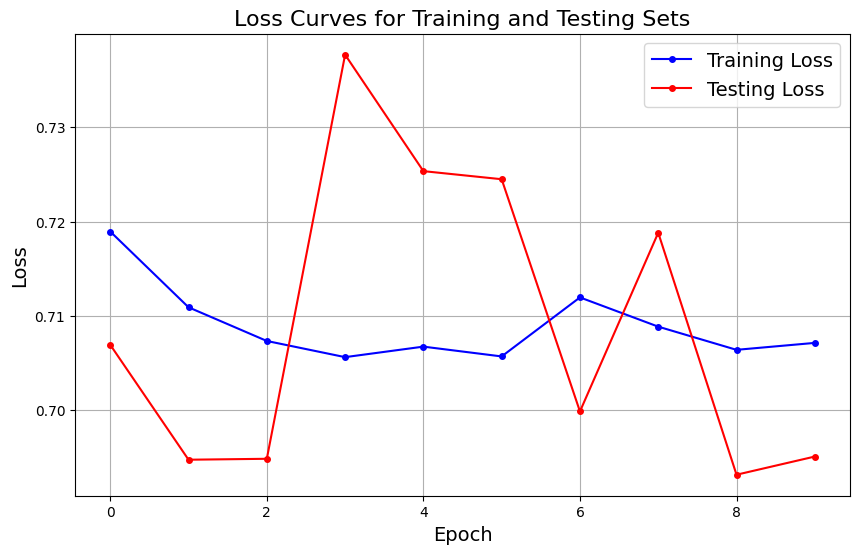

In [117]:
plot_loss_curves(losses_train, losses_test, file_name="mlp_loss_curves_large_1")

**Report what you observe on the training/test loss curves (related to a term we mentioned in the lecture)**

The toy moon dataset from Sklearn is a non-linearly separable dataset with two intertwined classes. The current MLP architecture with only two hidden layers may lack sufficient capacity to learn the complex patterns in the data, leading to high training loss and underfitting. Conversely, an excessively high capacity with multiple hidden layers may cause the model to overfit the training data, resulting in a low training loss but high test loss. Moreover, using Xavier or Glorot initialization for the weights instead of normal distribution initialization can enhance the model's learning capacity since the initialization helps to set the weights of the network to small random values that are inversely proportional to the square root of the number of input units in the previous layer. This ensures that the variance of the outputs of each layer remains consisten allowing gradients to flow through the network during backpropagation.


### Task 2: Data Preparation and Visualization

In [118]:
# prepare data for training and testing
def load_data(train=True):
    """Load train- test split for MNIST"""
    mnist = datasets.MNIST('../data',
                train=train,
                download=True)
    return mnist

In [119]:
# 1.1 Load MNIST dataset
# load train split
data_train = load_data(train=True)
data_test = load_data(train=False)

print(len(data_train))
print(len(data_test))

60000
10000


In [120]:
def plot_examples(data):
    """ Plot some examples and put their corresponding label on top as title."""
    train_set_array = np.fliplr(data.data.numpy()) # data is l-r flipped
    train_set_array_targets = data.targets.numpy()
    
    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for i in range(10):
        axs[i].contourf(train_set_array[i], 5, cmap=plt.cm.Greys)
        axs[i].set_title(train_set_array_targets[i]) 

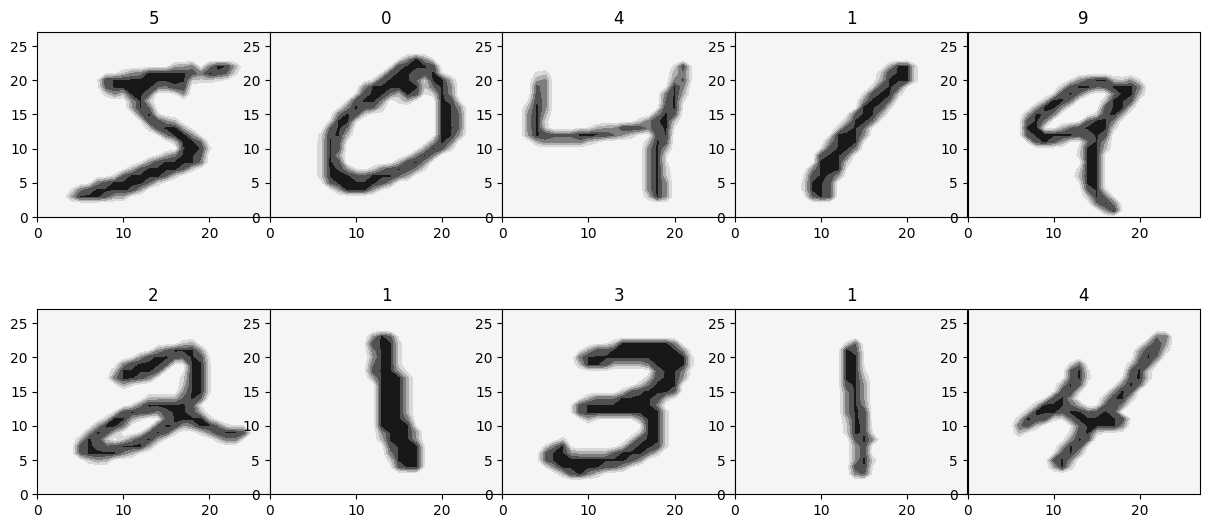

In [121]:
# 1.2 Plot some examples from the training set
plot_examples(data_train)

In [122]:
def plot_report(data: np.array) -> None:
    v_sum = np.sum(data)
    v_min = np.min(data)
    v_max = np.max(data)
    v_mean = np.mean(data)
    v_shape = data.shape
    v_dtype = data.dtype

    print("Report for train set")
    print(f"Train Sum: {v_sum}")
    print(f"Train Min: {v_min}")
    print(f"Train Max: {v_max}")
    print(f"Train Mean: {v_mean}")
    print(f"Train Shape: {v_shape}")
    print(f"Train Datatype: {v_dtype}")

In [123]:
# 1.3 Give a report about min, max, mean, and std of the training set
train_set_array = data_train.data.numpy() # data is l-r flipped
plot_report(train_set_array)

Report for train set
Train Sum: 1567298545
Train Min: 0
Train Max: 255
Train Mean: 33.318421449829934
Train Shape: (60000, 28, 28)
Train Datatype: uint8


In [124]:
def convert_mnist_to_vectors(data):
    '''Converts the ``[28, 28]`` MNIST images to vectors of size ``[28*28]``.
       It outputs mnist_vectors as a array with the shape of [N, 784], where
       N is the number of images in data.
    '''

    mnist_vectors = []
    labels = []

    for image, label in tqdm(data):
        img_array = np.asarray(image)
        img_array = np.reshape(img_array, -1) # reshape array to vector
        mnist_vectors.append(img_array)
        labels.append(label)

    # return as numpy arrays
    return np.array(mnist_vectors), labels


def norm_data(data: np.array) -> np.array:
    """Normalise vectors to be centered around 0 in a range of [-1, 1]"""
    data = data.copy()
    return 2*(data - np.min(data))/np.ptp(data) - 1

In [125]:
# 2. Convert all images into plain vectors and process them to be centered around 0
mnist_vectors, labels = convert_mnist_to_vectors(data_train)

# normalize data
mnist_vectors = norm_data(np.array(mnist_vectors))

print(mnist_vectors[:1].shape)
print(mnist_vectors.shape)

100%|██████████| 60000/60000 [00:00<00:00, 90386.11it/s]


(1, 784)
(60000, 784)


In [126]:
# Normalised [-1,1]
norm_mnist_mean = np.mean(mnist_vectors)
print(f"Train Mean: {norm_mnist_mean}")

Train Mean: -0.8714560195745021


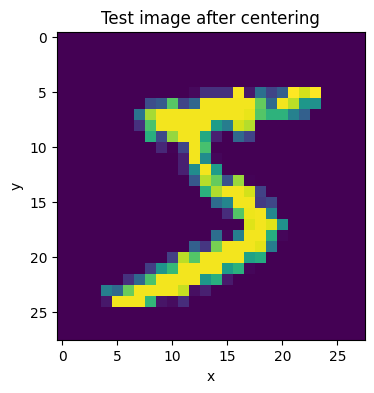

In [127]:
test_img = mnist_vectors[:1]
test_img = test_img.reshape((28, 28))
plt.imshow(test_img, interpolation='nearest')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test image after centering")
plt.show()

In [128]:
def do_pca(data):
    '''Returns matrix [784x784] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their
       eigenvalues in decreasing order.
    '''

    mnist_vectors, _ = convert_mnist_to_vectors(data)
    # prepare_data(mnist_vectors)

    # compute covariance matrix of data with shape [784x784]
    cov = np.cov(mnist_vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    print(type(sorted_eigenVectors), sorted_eigenVectors.shape)
    return sorted_eigenVectors.astype(np.float32).T

In [129]:
# 3. Run PCA on the MNIST dataset
eigenVectors = do_pca(data_train)

100%|██████████| 60000/60000 [00:00<00:00, 88009.35it/s]


<class 'numpy.ndarray'> (784, 784)


/var/folders/4h/v0fwv1zs4596mmdvwj516k840000gn/T/ipykernel_11444/1302327773.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  return sorted_eigenVectors.astype(np.float32).T


In [130]:
def plot_pcs(sorted_eigenVectors, num=10):
    '''Plots the first ``num`` eigenVectors as images.'''
    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for i in range(num):
        img = sorted_eigenVectors[i,].reshape((28, 28))
        axs[i].contourf(img, 5, cmap=plt.cm.Oranges)
        axs[i].set_title(f"Principal Component {i}")
    
    # save plot to results folder
    plt.savefig(f"{RESULTS_PATH}/pca_components.png", dpi=300)

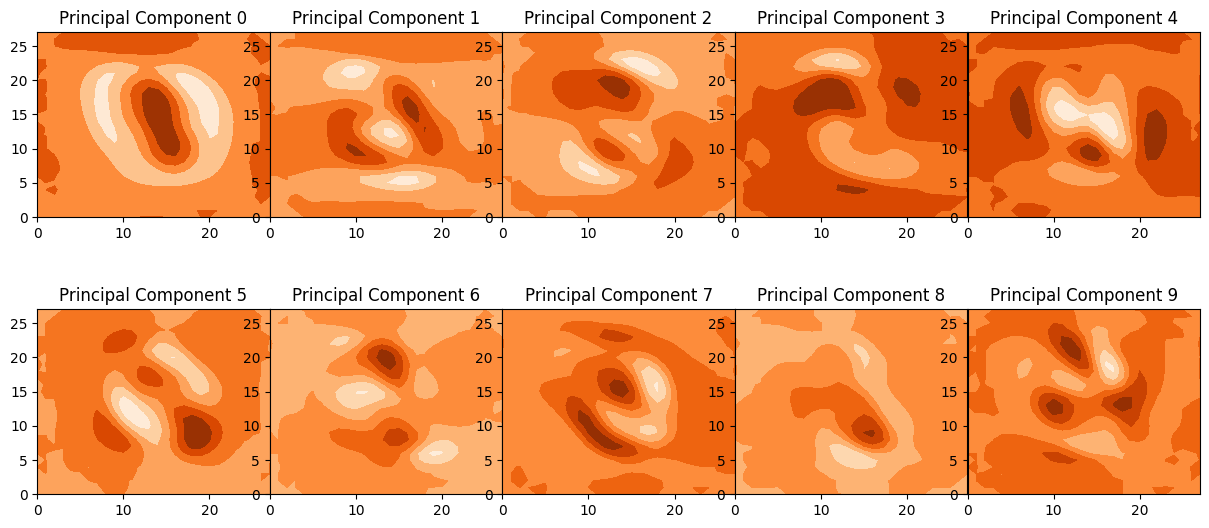

In [131]:
# 3.2 Plot the first 10 principal components
plot_pcs(eigenVectors)

**Explain what can be observed?**

The plots visualize the ten most important principal components, which allows to explain the greatest amount of variance in the original features. Thereby, PCA identifies directions (or principal components) along which the variation in the data is maximal. Hereby, it can be observed that the spread of the values is relatively large on the y-axis with relatively less spread (variance) on the x-axis. However, since the input data follows some wave-type structure (hand-written digits) after the projection the wave shapes also show up as distortion in the plots. Thereby, a linear correlation of the principal component values is not observable. The different values for the principal components do not show any clear linear relationship between the variance of the features in the dataset. We can derive that the classes are not linear seperable. The MNIST data further does not follow a multidimensional normal (Gaussian) distribution.

**What would you expect the principal components to look like, if the problem was easy?**

If the problem was easy a linear relationship, or strong linear correlation would be observable. However, the MNIST classes are not linearly seperable which makes the problem more challenging. Additionally, a large spread, or great variance is visible.

In [ ]:
# create random colours
from random import randint

def generate_colors(amount: int) -> list:
    colors = []
    for i in range(amount):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    return colors

In [ ]:
def project_vec_2Dspace(x, y):
    """ Use of the dot product to project vectors onto each other."""
    return (np.dot(x, y) / np.linalg.norm(y)**2 ) * y # (np.dot(x, y) / np.dot(y, y)) * y

In [ ]:
def plot_projection(sorted_eigenVectors, data, path=RESULTS_PATH):
    ''' Projects ``data`` onto the first two ``sorted_eigenVectors`` and makes
        a scatterplot of the resulting points
    '''
    N = 250
    # prepare data as vectors
    mnist_vectors, labels = convert_mnist_to_vectors(data)
    
    # projection of the vetors in 2D feature space
    pc1s = np.array([project_vec_2Dspace(x, y=sorted_eigenVectors[0]) for x in mnist_vectors[:N,]])
    pc2s = np.array([project_vec_2Dspace(x, y=sorted_eigenVectors[1]) for x in mnist_vectors[:N,]])

    # get random colours
    unique_labels = np.unique(labels[:N])
    cdict = generate_colors(len(unique_labels))

    # plot all datapoints 
    fig, ax = plt.subplots()
    for g in unique_labels:
        ix = np.where(labels[:N] == g)
        x = list(pc1s[ix])
        y = list(pc2s[ix])
        ax.scatter(x, y, c=cdict[g], marker='.', label=f'class {g}')
    ax.legend()
    ax.grid()
    plt.title(f'Two Component PCA with {N} Samples')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    fig.savefig(f'./{path}/pca.png', dpi=fig.dpi)

In [ ]:
# 4. Project the MNIST vectors of the train set onto the two most important principal components
# find the two main important PCs
two_main_components = eigenVectors[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, data_train)

### Task 3: Defining, Training and Evaluating an MLP

#### Task 4: Visualizing MLP Features